# Dysfunctional seed dispersal in the endemic flora of Madagascar

* Language: R
* Methods: linear regression, multivariate imputation by chained equations (MICE), spatial analyses
* Associated publication: (in prep)

<br>
<br>
## Map overlap between plants and lemurs

We want to create maps showing the distribution of interesting plant species and their potential dispersers. <br>
We are going to retain 2 plant species:<br>
__*Erythrophleum couminga*__ could potentially be dispersed by five lemur species (*Eulemur collaris*, *E. fulvus*, *E. macaco*, *Varecia rubra* and *V. variegata*) according to the size of its seeds. However, none of these lemurs remains in the western coastal and subcoastal area where the plant species is found.<br>
__*Eligmocarpus cynometroides*__ seems to have five available lemur dispersers, given our results. However, the last update of its distribution reported only one persisting population with only 21 individuals (Devey et al. 2013). Given these data, this plant species has only one remaining available disperser (*Lemur catta*). It is confined to a very small area of south-east Madagascar, near a mining site and between villages, and shows clear evidence of disrupted dispersal, such as an absence of regeneration and large piles of rotten fruits below the trees (Buerki et al. 2015; Devey et al. 2013). *Eligmocarpus cynometroides* is now critically endangered. 

In [52]:
library(dismo);
library(ggplot2);
library(ggmap);
library(maptools);

Function scale_bar from http://egallic.fr/scale-bar-and-north-arrow-on-a-ggplot2-map/ to plot a North arrow and a scale on a Google map.

In [53]:
# We need a function to get the scale bar coordinates
#
# Result #
#--------#
# Return a list whose elements are :
# 	- rectangle : a data.frame containing the coordinates to draw the first rectangle ;
# 	- rectangle2 : a data.frame containing the coordinates to draw the second rectangle ;
# 	- legend : a data.frame containing the coordinates of the legend texts, and the texts as well.
#
# Arguments : #
#-------------#
# lon, lat : longitude and latitude of the bottom left point of the first rectangle to draw ;
# distance_lon : length of each rectangle ;
# distance_lat : width of each rectangle ;
# distance_legend : distance between rectangles and legend texts ;
# dist_units : units of distance "km" (kilometers) (default), "nm" (nautical miles), "mi" (statute miles).

create_scale_bar <- function(lon,lat,distance_lon,distance_lat,distance_legend, dist_units = "km"){
    # First rectangle
    bottom_right <- gcDestination(lon = lon, lat = lat, bearing = 90, dist = distance_lon, dist.units = dist_units, model = "WGS84")
    
    topLeft <- gcDestination(lon = lon, lat = lat, bearing = 0, dist = distance_lat, dist.units = dist_units, model = "WGS84")
    rectangle <- cbind(lon=c(lon, lon, bottom_right[1,"long"], bottom_right[1,"long"], lon),
    lat = c(lat, topLeft[1,"lat"], topLeft[1,"lat"],lat, lat))
    rectangle <- data.frame(rectangle, stringsAsFactors = FALSE)
    
    # Second rectangle t right of the first rectangle
    bottom_right2 <- gcDestination(lon = lon, lat = lat, bearing = 90, dist = distance_lon*2, dist.units = dist_units, model = "WGS84")
    rectangle2 <- cbind(lon = c(bottom_right[1,"long"], bottom_right[1,"long"], bottom_right2[1,"long"], bottom_right2[1,"long"], bottom_right[1,"long"]),
    lat=c(lat, topLeft[1,"lat"], topLeft[1,"lat"], lat, lat))
    rectangle2 <- data.frame(rectangle2, stringsAsFactors = FALSE)
    
    # Now let's deal with the text
    on_top <- gcDestination(lon = lon, lat = lat, bearing = 0, dist = distance_legend, dist.units = dist_units, model = "WGS84")
    on_top2 <- on_top3 <- on_top
    on_top2[1,"long"] <- bottom_right[1,"long"]
    on_top3[1,"long"] <- bottom_right2[1,"long"]
    
    legend <- rbind(on_top, on_top2, on_top3)
    legend <- data.frame(cbind(legend, text = c(0, distance_lon, distance_lon*2)), stringsAsFactors = FALSE, row.names = NULL)
    return(list(rectangle = rectangle, rectangle2 = rectangle2, legend = legend))
}




# We also need a function to obtain the coordinates of the North arrow
#
# Result #
#--------#
# Returns a list containing :
#	- res : coordinates to draw an arrow ;
#	- coordinates of the middle of the arrow (where the "N" will be plotted).
#
# Arguments : #
#-------------#
# scale_bar : result of create_scale_bar() ;
# length : desired length of the arrow ;
# distance : distance between legend rectangles and the bottom of the arrow ;
# dist_units : units of distance "km" (kilometers) (default), "nm" (nautical miles), "mi" (statute miles).
create_orientation_arrow <- function(scale_bar, length, distance = 1, dist_units = "km"){
    lon <- scale_bar$rectangle2[1,1]
    lat <- scale_bar$rectangle2[1,2]
    
    # Bottom point of the arrow
    beg_point <- gcDestination(lon = lon, lat = lat, bearing = 0, dist = distance, dist.units = dist_units, model = "WGS84")
    lon <- beg_point[1,"long"]
    lat <- beg_point[1,"lat"]
    
    # Let us create the endpoint
    on_top <- gcDestination(lon = lon, lat = lat, bearing = 0, dist = length, dist.units = dist_units, model = "WGS84")
    
    left_arrow <- gcDestination(lon = on_top[1,"long"], lat = on_top[1,"lat"], bearing = 225, dist = length/5, dist.units = dist_units, model = "WGS84")
    
    right_arrow <- gcDestination(lon = on_top[1,"long"], lat = on_top[1,"lat"], bearing = 135, dist = length/5, dist.units = dist_units, model = "WGS84")
    
    res <- rbind(
            cbind(x = lon, y = lat, xend = on_top[1,"long"], yend = on_top[1,"lat"]),
            cbind(x = left_arrow[1,"long"], y = left_arrow[1,"lat"], xend = on_top[1,"long"], yend = on_top[1,"lat"]),
            cbind(x = right_arrow[1,"long"], y = right_arrow[1,"lat"], xend = on_top[1,"long"], yend = on_top[1,"lat"]))
    
    res <- as.data.frame(res, stringsAsFactors = FALSE)
    
    # Coordinates from which "N" will be plotted
    coords_n <- cbind(x = lon, y = (lat + on_top[1,"lat"])/2)
    
    return(list(res = res, coords_n = coords_n))
}



# The last function enables the user to draw the elements
#
# Result #
#--------#
# This function enables to draw a scale bar on a ggplot object, and optionally an orientation arrow #
# Arguments : #
#-------------#
# lon, lat : longitude and latitude of the bottom left point of the first rectangle to draw ;
# distance_lon : length of each rectangle ;
# distance_lat : width of each rectangle ;
# distance_legend : distance between rectangles and legend texts ;
# dist_units : units of distance "km" (kilometers) (by default), "nm" (nautical miles), "mi" (statute miles) ;
# rec_fill, rec2_fill : filling colour of the rectangles (default to white, and black, resp.);
# rec_colour, rec2_colour : colour of the rectangles (default to black for both);
# legend_colour : legend colour (default to black);
# legend_size : legend size (default to 3);
# orientation : (boolean) if TRUE (default), adds an orientation arrow to the plot ;
# arrow_length : length of the arrow (default to 500 km) ;
# arrow_colour :arrow colour (default to black);
# arrow_yshift : vertical shift of the arrow, i.e.  distance between the scale bar and the bottom of the arrow (default to 300 km) ;
# arrow_north_size : size of the "N" letter (default to 6);
# arrow_north_colour : colour of the "N" letter (default to black);
# arrow_north_xshift : horizontal shift of the "N" letter (default to 0, i.e. N over the arrow; negative value=shift to the left; positive value=shift to the right)
# arrow_north_yshift : vertical shift of the "N" letter (default to 0, i.e. N over the arrow; negative value=shift to the bottom; positive value=shift to the top)

scale_bar <- function(lon, lat, distance_lon, distance_lat, distance_legend, dist_unit = "km", rec_fill = "white", rec_colour = "black", rec2_fill = "black", rec2_colour = "black", legend_colour = "black", legend_size = 3, orientation = TRUE, arrow_length = 500, arrow_colour = "black", arrow_yshift = 300, arrow_north_size = 6, arrow_north_colour = "black", arrow_north_xshift = 0, arrow_north_yshift = 0){
    the_scale_bar <- create_scale_bar(lon = lon, lat = lat, distance_lon = distance_lon, distance_lat = distance_lat, distance_legend = distance_legend, dist_unit = dist_unit)
    # First rectangle
    rectangle1 <- geom_polygon(data = the_scale_bar$rectangle, aes(x = lon, y = lat), fill = rec_fill, colour = rec_colour)
    
    # Second rectangle
    rectangle2 <- geom_polygon(data = the_scale_bar$rectangle2, aes(x = lon, y = lat), fill = rec2_fill, colour = rec2_colour)
    
    # Legend
    scale_bar_legend <- annotate("text", label = paste(the_scale_bar$legend[,"text"], dist_unit, sep=""), x = the_scale_bar$legend[,"long"], y = the_scale_bar$legend[,"lat"], size = legend_size, colour = legend_colour)
    
    res <- list(rectangle1, rectangle2, scale_bar_legend)
    
    if(orientation){# Add an arrow pointing North
        coords_arrow <- create_orientation_arrow(scale_bar = the_scale_bar, length = arrow_length, distance = arrow_yshift, dist_unit = dist_unit)
        arrow <- list(geom_segment(data = coords_arrow$res, aes(x = x, y = y, xend = xend, yend = yend), colour= arrow_colour), annotate("text", label = "N", x = coords_arrow$coords_n[1,"x"] + arrow_north_xshift, y = coords_arrow$coords_n[1,"y"] + arrow_north_yshift, size = arrow_north_size, colour = arrow_north_colour))
        res <- c(res, arrow)
    }
    return(res)
}

##### Load data

In [54]:
## Load vegetation rasters
matveg <- expand.grid(For=c("no","yes"), Bush=c("no","yes"), Grass=c("no","yes"), Anthr=c("no","yes")) # combination matrix
matveg <- matveg[-1,]        # remove first line (with "no" only)

for (c in 1:nrow(matveg)) {
	combveg <- names(matveg[, matveg[c,]=="yes", drop=FALSE]) 
	combname <- paste(combveg, collapse="")
	namerasterveg <- paste("raster", combname, sep="")
	namerastervegAggprtif <- paste(namerasterveg, "Aggpr.tif", sep="") 
	assign(namerasterveg, raster(namerastervegAggprtif))
	namerasterveg[namerasterveg==0] <- NA
}


## Load base map
rasterBase <- raster("rasterBaseAggpr.tif")
proj4string(rasterBase) <- CRS("+proj=longlat +ellps=WGS84 +datum=WGS84")


## Load base data
traitendo <- read.csv("traitveg1.csv")
traitendo <- subset(traitendo, SyndAB2 == "Biotic")
dat <- read.table("Plant_coord.txt", sep="\t", header=TRUE)


## Load lemur rasters (only the ones needed for the two maps we want to create)
rasterlemEC <- raster("rasterEulemur_collaris.tif")
rasterlemEF <- raster("rasterEulemur_fulvus.tif")
rasterlemEM <- raster("rasterEulemur_macaco.tif")
rasterlemVR <- raster("rasterVarecia_rubra.tif")
rasterlemVV <- raster("rasterVarecia_variegata.tif")
rasterlemCM <- raster("rasterCheirogaleus_major.tif")
rasterlemCMs <- raster("rasterCheirogaleus_medius.tif")
rasterlemLC <- raster("rasterLemur_catta.tif")
rasterlemMR <- raster("rasterMicrocebus_rufus.tif")

##### Erythrophleum couminga

Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Madagascar&zoom=6&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Madagascar&sensor=false
Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

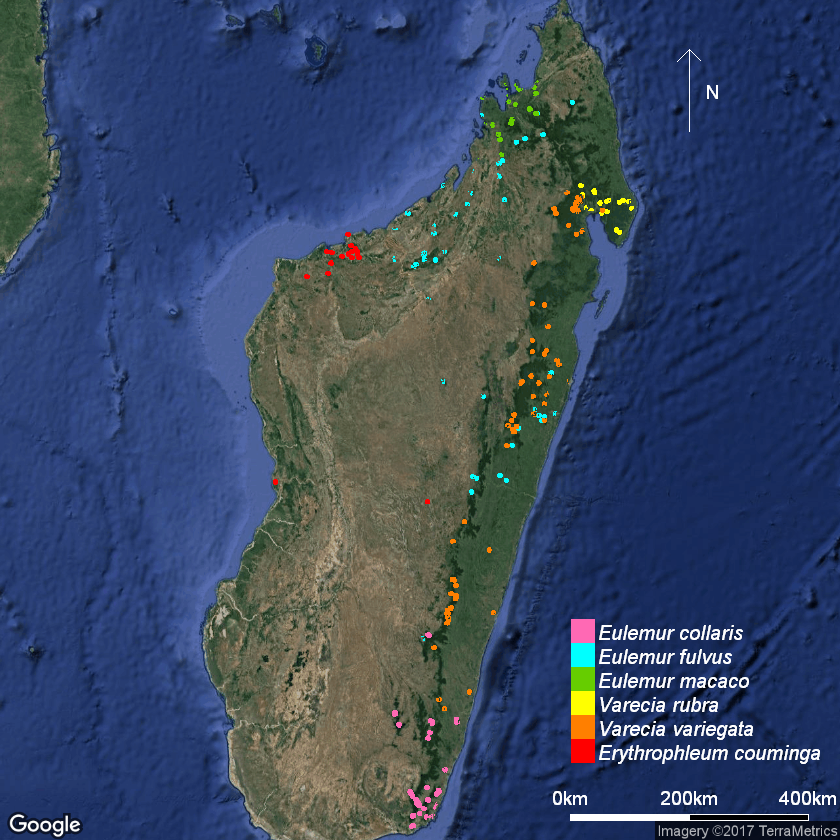

In [55]:
## Load plant raster
dats <- subset(dat, species=="Erythrophleum_couminga")
x <- dats$decimalLongitude
y <- dats$decimalLatitude
coord <- data.frame(x,y)
rasterpls <- rasterize(coord, rasterBase, field=1)
traitendos <- subset(traitendo, .id=="Erythrophleum_couminga")
vegtypes <- names(traitendos[, traitendos[1,]=="yes", drop=FALSE]) 
	if (length(vegtypes) != 0) {
	combnames <- paste(vegtypes, collapse="")
	namerasterveg <- paste("raster", combnames, sep="")
	rasterveg <- get(namerasterveg)
	projection(rasterpls) <- projection(rasterveg)
	rasterpls <- mask(rasterpls, rasterveg)
	} 
projection(rasterpls) <- projection(rasterveg)
rasterpls <- mask(rasterpls, rasterveg)	

rasterpls2 <- buffer(rasterpls, width=5000)  # Create 5000-m buffer circles around each plant cell (to increase visibility)



## Create polygons for each lemur species and Erythrophleum couminga
rtpEC <- rasterToPolygons(rasterlemEC)
rtpEC@data$id <- 1:nrow(rtpEC@data)   # add id column for join
rtpECFort <- fortify(rtpEC, data = rtpEC@data)
rtpECFortMer <- merge(rtpECFort, rtpEC@data, by.x = 'id', by.y = 'id')  # join data

rtpEF <- rasterToPolygons(rasterlemEF)
rtpEF@data$id <- 1:nrow(rtpEF@data)   # add id column for join
rtpEFFort <- fortify(rtpEF, data = rtpEF@data)
rtpEFFortMer <- merge(rtpEFFort, rtpEF@data, by.x = 'id', by.y = 'id')  # join data

rtpEM <- rasterToPolygons(rasterlemEM)
rtpEM@data$id <- 1:nrow(rtpEM@data)   # add id column for join
rtpEMFort <- fortify(rtpEM, data = rtpEM@data)
rtpEMFortMer <- merge(rtpEMFort, rtpEM@data, by.x = 'id', by.y = 'id')  # join data

rtpVR <- rasterToPolygons(rasterlemVR)
rtpVR@data$id <- 1:nrow(rtpVR@data)   # add id column for join
rtpVRFort <- fortify(rtpVR, data = rtpVR@data)
rtpVRFortMer <- merge(rtpVRFort, rtpVR@data, by.x = 'id', by.y = 'id')  # join data

rtpVV <- rasterToPolygons(rasterlemVV)
rtpVV@data$id <- 1:nrow(rtpVV@data)   # add id column for join
rtpVVFort <- fortify(rtpVV, data = rtpVV@data)
rtpVVFortMer <- merge(rtpVVFort, rtpVV@data, by.x = 'id', by.y = 'id')  # join data

rtpP <- rasterToPolygons(rasterpls2)
rtpP@data$id <- 1:nrow(rtpP@data)   # add id column for join
rtpPFort <- fortify(rtpP, data = rtpP@data)
rtpPFortMer <- merge(rtpPFort, rtpP@data, by.x = 'id', by.y = 'id')  # join data




## Load Mada map
bm <- ggmap(get_map("Madagascar", zoom=6, scale=2, maptype="satellite"), extent="device")   # extent=”device” argument stretches the map to fill the whole graphics device



## Plot map
bm + 	geom_polygon(data = rtpECFortMer, 
                  aes(x = long, y = lat, group = group, fill="1"), show.legend =TRUE,
                  size = 0)  	+ 
	geom_polygon(data = rtpEFFortMer, 
                  aes(x = long, y = lat, group = group, fill="2"),  show.legend =TRUE,
                  size = 0) 	+
	geom_polygon(data = rtpEMFortMer, 
                  aes(x = long, y = lat, group = group, fill="3"),  show.legend =TRUE,
                  size = 0) 	+
	geom_polygon(data = rtpVRFortMer, 
                  aes(x = long, y = lat, group = group, fill="4"), show.legend =TRUE, 
                  size = 0) 	+
	geom_polygon(data = rtpVVFortMer, 
                  aes(x = long, y = lat, group = group, fill="5"), show.legend =TRUE,
                   size = 0) 	+
	geom_polygon(data = rtpPFortMer, 
                  aes(x = long, y = lat, group = group, fill="6"),  show.legend =TRUE,
                  size = 0) 	+

	scale_fill_manual(breaks=c("1","2","3","4","5","6"),
		values=c("hotpink", "cyan", "chartreuse3", "yellow", "darkorange1", "red"),
		labels=c("Eulemur collaris", "Eulemur fulvus", "Eulemur macaco", "Varecia rubra", "Varecia variegata", "Erythrophleum couminga"))	+
	theme(legend.title=element_blank())	+
	scale_bar(lon = 49.4, lat = -25,                  
              	distance_lon = 200, distance_lat = 10, 
              	distance_legend = 40, legend_size = 4, dist_unit = "km", rec_colour="white", rec2_colour="white", legend_colour="white",
		arrow_length = 150, arrow_yshift = 1200, arrow_north_size = 4, arrow_colour="white", arrow_north_colour="white", arrow_north_xshift=0.4)	+
	theme(legend.justification=c(1,0.1),
		legend.position=c(1,0.1),
		legend.text = element_text(size = 12, colour = "white", face="italic"),
		legend.background = element_blank(),            # remove white background of the legend
		legend.key=element_blank()                      # remove white line around keys (i.e. colored squares)
)	+	
	guides(fill = guide_legend(keywidth = 1, keyheight = 1))        # change size of keys

Map showing the distribution of Erythrophleum couminga and the five lemur species (*Eulemur collaris*, *E. fulvus*, *E. macaco*, *Varecia rubra* and *V. variegata*) which could potentially disperse its seeds (based on seed size). Note that none of these lemur species still co-occurs with *Erythrophleum couminga*.

##### Eligmocarpus_cynometroides

Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Madagascar,+Manambaro&zoom=11&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Madagascar,%20Manambaro&sensor=false
Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

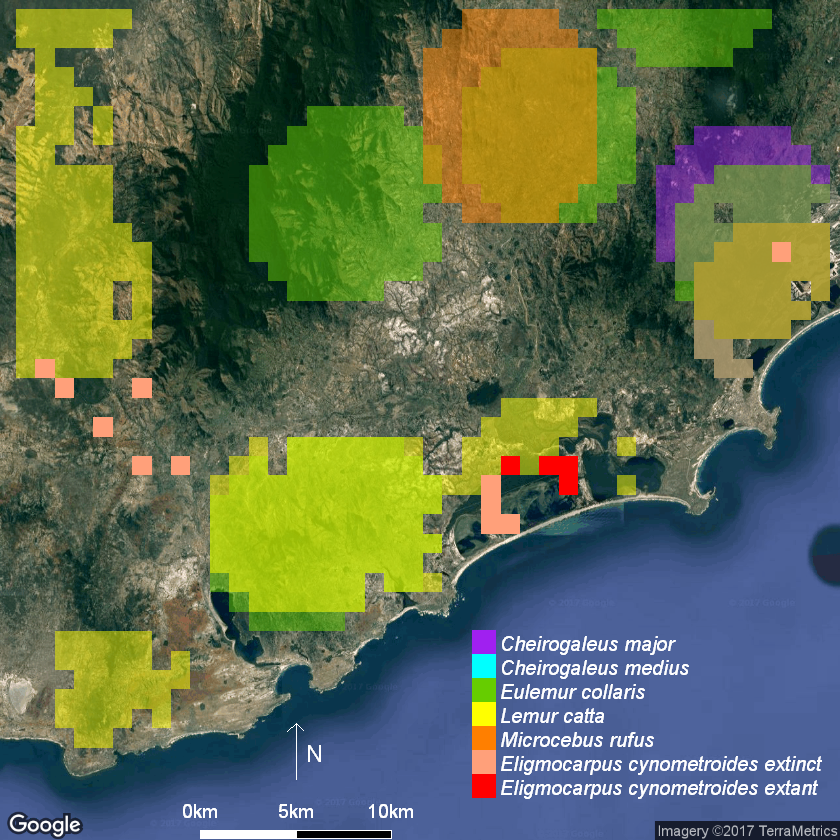

In [58]:
## Load plant raster (out-of-date)
dats <- subset(dat, species=="Eligmocarpus_cynometroides")
x <- dats$decimalLongitude
y <- dats$decimalLatitude
coord <- data.frame(x,y)
rasterpls <- rasterize(coord, rasterBase, field=1)
traitendos <- subset(traitendo, .id=="Eligmocarpus_cynometroides")
vegtypes <- names(traitendos[, traitendos[1,]=="yes", drop=FALSE]) 
	if (length(vegtypes) != 0) {
	combnames <- paste(vegtypes, collapse="")
	namerasterveg <- paste("raster", combname, sep="")
	rasterveg <- get(namerasterveg)
	projection(rasterpls) <- projection(rasterveg)
	rasterpls <- mask(rasterpls, rasterveg)
	} 
projection(rasterpls) <- projection(rasterveg)
rasterplsold <- mask(rasterpls, rasterveg)



## Load plant raster (up-to-date)
dats <- read.csv("dats-Eli-new.csv",sep=";")
x <- dats$decimalLongitude
y <- dats$decimalLatitude
coord <- data.frame(x,y)
rasterpls <- rasterize(coord, rasterBase, field=1)
traitendos <- subset(traitendo, .id=="Eligmocarpus_cynometroides")
vegtypes <- names(traitendos[, traitendos[1,]=="yes", drop=FALSE]) 
	if (length(vegtypes) != 0) {
	combnames <- paste(vegtypes, collapse="")
	namerasterveg <- paste("raster", combname, sep="")
	rasterveg <- get(namerasterveg)
	projection(rasterpls) <- projection(rasterveg)
	rasterpls <- mask(rasterpls, rasterveg)
	} 
projection(rasterpls) <- projection(rasterveg)
rasterplsnew <- mask(rasterpls, rasterveg)



## Create polygons
rtpCM <- rasterToPolygons(rasterlemCM)
rtpCM@data$id <- 1:nrow(rtpCM@data)   # add id column for join
rtpCMFort <- fortify(rtpCM, data = rtpCM@data)
rtpCMFortMer <- merge(rtpCMFort, rtpCM@data, by.x = 'id', by.y = 'id')  # join data

rtpCMs <- rasterToPolygons(rasterlemCMs)
rtpCMs@data$id <- 1:nrow(rtpCMs@data)   # add id column for join
rtpCMsFort <- fortify(rtpCMs, data = rtpCMs@data)
rtpCMsFortMer <- merge(rtpCMsFort, rtpCMs@data, by.x = 'id', by.y = 'id')  # join data

rtpEC <- rasterToPolygons(rasterlemEC)
rtpEC@data$id <- 1:nrow(rtpEC@data)   # add id column for join
rtpECFort <- fortify(rtpEC, data = rtpEC@data)
rtpECFortMer <- merge(rtpECFort, rtpEC@data, by.x = 'id', by.y = 'id')  # join data

rtpLC <- rasterToPolygons(rasterlemLC)
rtpLC@data$id <- 1:nrow(rtpLC@data)   # add id column for join
rtpLCFort <- fortify(rtpLC, data = rtpLC@data)
rtpLCFortMer <- merge(rtpLCFort, rtpLC@data, by.x = 'id', by.y = 'id')  # join data

rtpMR <- rasterToPolygons(rasterlemMR)
rtpMR@data$id <- 1:nrow(rtpMR@data)   # add id column for join
rtpMRFort <- fortify(rtpMR, data = rtpMR@data)
rtpMRFortMer <- merge(rtpMRFort, rtpMR@data, by.x = 'id', by.y = 'id')  # join data

rtpPold <- rasterToPolygons(rasterplsold)
rtpPold@data$id <- 1:nrow(rtpPold@data)   # add id column for join
rtpPoldFort <- fortify(rtpPold, data = rtpPold@data)
rtpPoldFortMer <- merge(rtpPoldFort, rtpPold@data, by.x = 'id', by.y = 'id')  # join data

rtpPnew <- rasterToPolygons(rasterplsnew)
rtpPnew@data$id <- 1:nrow(rtpPnew@data)   # add id column for join
rtpPnewFort <- fortify(rtpPnew, data = rtpPnew@data)
rtpPnewFortMer <- merge(rtpPnewFort, rtpPnew@data, by.x = 'id', by.y = 'id')  # join data


## Load Mada map
bm <- ggmap(get_map("Madagascar, Manambaro", zoom=11, scale=2, maptype="satellite"), extent="device")   # extent=”device” argument stretches the map to fill the whole graphics device


## Plot map
bm + 	geom_polygon(data = rtpCMFortMer, 
                  aes(x = long, y = lat, group = group, fill="1"), show.legend =TRUE, 
		alpha=0.5,	
                  size = 0)  	+
	geom_polygon(data = rtpCMsFortMer, 
                  aes(x = long, y = lat, group = group, fill="2"),  show.legend =TRUE,
		alpha=0.5,
                  size = 0) 	+
	geom_polygon(data = rtpECFortMer, 
                  aes(x = long, y = lat, group = group, fill="3"),  show.legend =TRUE,
		alpha=0.5,	
                  size = 0) 	+
	geom_polygon(data = rtpLCFortMer, 
                  aes(x = long, y = lat, group = group, fill="4"), show.legend =TRUE, 
		alpha=0.5,
                  size = 0) 	+
	geom_polygon(data = rtpMRFortMer, 
                  aes(x = long, y = lat, group = group, fill="5"), show.legend =TRUE,
		alpha=0.5,
                   size = 0) 	+
	geom_polygon(data = rtpPoldFortMer, 
                  aes(x = long, y = lat, group = group, fill="6"),  show.legend =TRUE,
                  size = 0) 	+
	geom_polygon(data = rtpPnewFortMer, 
                  aes(x = long, y = lat, group = group, fill="7"),  show.legend =TRUE,
                  size = 0) 	+

	scale_fill_manual(breaks=c("1","2","3","4","5","6","7"),
		values=c("purple", "cyan", "chartreuse3", "yellow", "darkorange1", "lightsalmon","red"),
		labels=c("Cheirogaleus major", "Cheirogaleus medius", "Eulemur collaris", "Lemur catta", "Microcebus rufus", "Eligmocarpus cynometroides extinct", "Eligmocarpus cynometroides extant"))	+
	theme(legend.title=element_blank())	+
	scale_bar(lon = 46.7, lat = -25.23,
              	distance_lon = 5, distance_lat = 0.4, 
              	distance_legend = 1.5, legend_size = 4, dist_unit = "km", rec_colour="white", rec2_colour="white", legend_colour="white",
		arrow_length = 3, arrow_yshift = 3, arrow_north_size = 5, arrow_colour="white", arrow_north_colour="white",  arrow_north_xshift= 0.01, arrow_north_yshift= 0)	+
	theme(legend.justification=c(1,0.05),
		legend.position=c(1,0.05),
		legend.text = element_text(size = 12, colour = "white", face="italic"),
		legend.background = element_blank(),         # remove white background of the legend
		legend.key=element_blank()                   # remove white line around keys (i.e. colored squares)
)	+	
	guides(fill = guide_legend(keywidth = 1, keyheight = 1))    # change size of keys

Map showing the distribution of *Eligmocarpus cynometroides* (recently extinct and extant individuals) and the five lemur species (*Cheirogaleus major*, *C. medius*, *Eulemur collaris*, *Lemur catta* and *Microcebus rufus*) which could be able to disperse its seeds. Note that only one (*Lemur catta*) still co-occur with E. cynometroides.

<div class="alert alert-block alert-success">
These results suggested that __at least 625__ Madagascar’s endemic endozoochorous species suffer from __dysfunctional dispersal__ due to __disperser loss__. <br>
* For __16 species__, this is due to the __complete extinction__ of their main dispersers, highlighted by the mismatch between seed size and maximum ingestible food size of extant dispersers. 
* For at least __609 species__, this is due to the __local extinction__ of potential dispersers. As a consequence of deforestation, habitat fragmentation and hunting, extant lemur populations are decimated and many species do not co-occur anymore with the plants whose seeds they could disperse. 